Automatically created module for IPython interactive environment


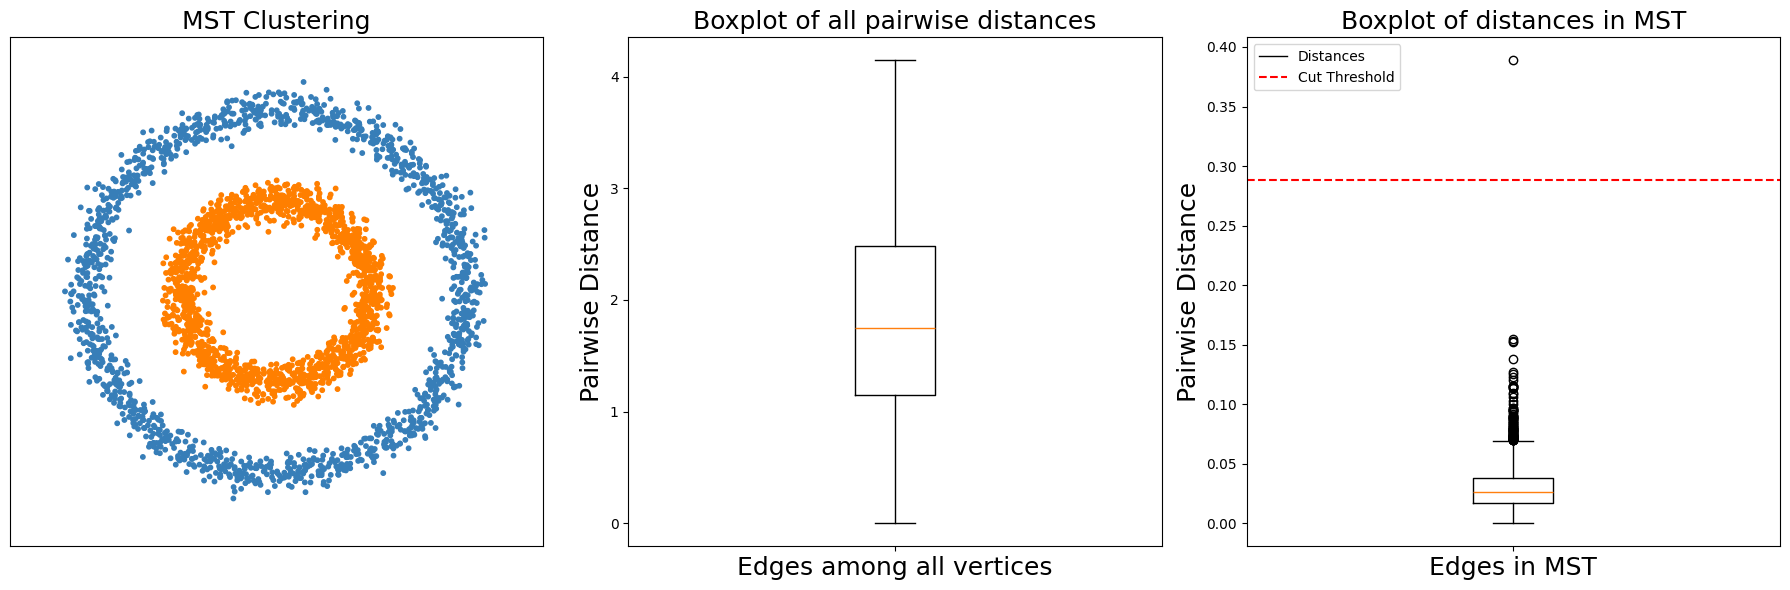

In [3]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components

plt.style.use('default')

np.random.seed(0)
n_samples = 3000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(18,6))


# plot_num = 1

X, y = noisy_circles

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Compute pairwise distances
distances = pdist(X, metric='euclidean')
distance_matrix = squareform(distances)

# Compute minimum spanning tree
mst_sparse = minimum_spanning_tree(distance_matrix)
mst_sparse = mst_sparse.tocoo()

# Get the edge and weights from the MST
edges = list(zip(mst_sparse.row, mst_sparse.col, mst_sparse.data))

# Sort the edges by weight in descending order
edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)

# Determine the number of clusters 
num_clusters = 2

# Remove the (num_clusters-1) largest edges to form clusters
edges_to_remove = num_clusters - 1

# Create a copy of the MST adjacency matrix
mst_adj_matrix = mst_sparse.toarray()

# Remove the largest edges
for i in range(edges_to_remove):
    max_edge = edges_sorted[i]

    # Since the MST  is undirected, remove both [row, col] and [col, row]
    mst_adj_matrix[max_edge[0], max_edge[1]] = 0
    mst_adj_matrix[max_edge[1], max_edge[0]] = 0

# Compute connected components (clusters)
n_components, labels = connected_components(mst_adj_matrix, directed=False)

# Plot the left subfigure (scatter plot with MST clusters)
plt.subplot(1, 3, 1)
plt.title('MST Clustering', size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                        '#f781bf', '#a65628', '#984ea3',
                                        '#999999', '#e41a1c', '#dede00']),
                                int(1 + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(())
plt.yticks(())

# Get the edge weights
edge_weights = mst_sparse.data
# Sort the edge weights
sorted_weights = np.sort(edge_weights)
# Compute the difference between consecutive weights
differences = np.diff(sorted_weights)
# Find the largest differences between consecutive weights
max_gap_index = np.argmax(differences)

# plot  the right subfigure (box plot of pairwise distances)
plt.subplot(1, 3, 2)
plt.boxplot(distances, vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.xticks([1],['Edges among all vertices'], size=18)
plt.title('Boxplot of all pairwise distances', size=18)


# Draw a hoorizontal line indicating the threshold used to cut the MST
threshold = edges_sorted[0][2] # Weight of the largest edge

# plot  the right subfigure (sorted MST edge weights)
plt.subplot(1, 3, 3)
plt.boxplot(sorted_weights, vert=True)
plt.ylabel('Pairwise Distance', size=18)
plt.xticks([1],['Edges in MST'], size=18)
plt.axhline(y=threshold-0.1, color='r', linestyle='--')
plt.title('Boxplot of distances in MST', size=18)
plt.legend(['Distances', 'Cut Threshold'], loc='upper left')

plt.tight_layout()    
plt.savefig('Clustering_and_distance_boxplot.png', transparent='True')
plt.show()